In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
scene = 'outdoor'

(384, 384)


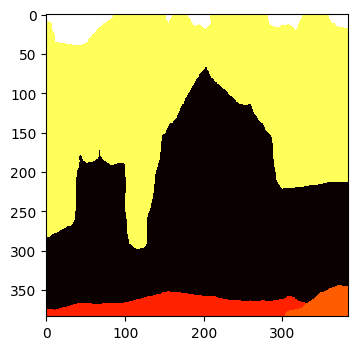

In [24]:
img = cv2.imread("../data/scene/output-seg/outdoor-bw/a_abbey_abbey_000004.png", 0)
plt.imshow(img, cmap='hot')
print img.shape

In [8]:
print np.unique(image)

[ 4  7  9 10 14 16]


In [13]:
with open("../data/scene/outdoor/palette.txt", "r") as fp:
    colors = np.array([map(int, line.strip().split()) for line in fp])

In [15]:
!cat ../data/scene/outdoor/labels.txt

#0:	__background__
#1: 	 airplane
#2: 	 balcony
#3: 	 bench
#4: 	 building
#5: 	 car
#6: 	 door
#7: 	 fence
#8: 	 gate
#9: 	 grass
#10: 	 path
#11: 	 road
#12: 	 rock
#13: 	 sign
#14: 	 sky
#15: 	 streetlight
#16: 	 tree
#17: 	 van
#18: 	 water


In [16]:
import caffe

In [17]:
net = caffe.Net('../data/scene/outdoor/deploy.prototxt', '../data/scene/outdoor/snapshot_iter_4230.caffemodel', caffe.TEST)

In [19]:
import scipy
with open('../data/scene/outdoor/mean.binaryproto', 'rb') as f:
    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.MergeFromString(f.read())
    mean_image = np.reshape(blob.data, (3, 384, 384))
    data_shape = tuple((1, 3, 384, 384))
    assert len(data_shape) == 4, 'Bad data shape.'
    mean_image = mean_image.astype(np.uint8)
    mean_image = mean_image.transpose(1, 2, 0)
    shape = list(mean_image.shape)
    mean_image = scipy.misc.imresize(mean_image, (data_shape[2], data_shape[3]))
    mean_image = mean_image.transpose(2, 0, 1)
    mean_image = mean_image.astype('float')


transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_channel_swap('data', (2, 1, 0))
transformer.set_mean('data', mean_image)

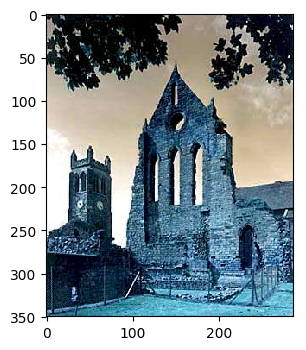

In [20]:
image = cv2.imread("../data/scene/test/outdoor/a_abbey_abbey_000004.jpg")
plt.imshow(image)

In [21]:
transformed_image = transformer.preprocess('data', image[:, :, (2, 1, 0)])
net.blobs['data'].data[0] = transformed_image
output = net.forward()
segmented = output['fc_final_up']
segmentation = segmented[0].argmax(axis=0)

/Users/danilonunes/.virtualenvs/imret2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
segmentation.shape

(384, 384)

In [42]:
with open('../data/scene/outdoor/labels.txt', 'r') as fp:
    labels = dict([line.replace('#', '').replace(':', '').strip().split() for line in fp.readlines()])

In [51]:
np.all(img == segmentation)
segmented = segmentation

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [27]:
import skimage
img_ = skimage.io.imread('../data/scene/output-seg/outdoor-bw/a_abbey_abbey_000004.png')

In [28]:
np.all(img_ == img)

True

In [30]:
from imret.dataset import Dataset
from imret.color import ColorPalette
from imret.query import Annotation

color_palette = ColorPalette(name_conversion='../data/query/name_conversion.csv')
dset = Dataset('../data/datasets/', 'test', '../data/images/')
annot = Annotation('../data/query/test_anno/')

In [32]:
ground_truth = dset.ground_truth('a_abbey_abbey_000004.jpg')

In [68]:
w, h = img.shape[:2]
fy = segmented.shape[0] / float(w)
fx = segmented.shape[1] / float(h)
scale = np.array([fx, fy])

In [60]:
import re
colors = {v: k for k, v in labels.items()}
for object_name, contour in ground_truth.items():
    name = re.match('\D+', object_name).group()
    name = color_palette.class_names.get(name, name)
#     try:
#         class_id = color_palette.class_id(name)
#         color = color_palette[name]
#     except ValueError:
#         continue
        
    if name not in labels.values():
        print(name)
        continue
    class_id = int(colors[name])
    break

('building', 4)


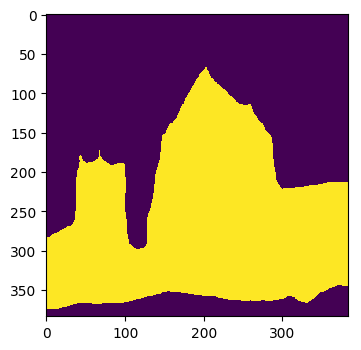

In [61]:
print(name, class_id)
img1 = np.zeros(segmented.shape, dtype=np.uint8)
x, y = np.where(segmented == class_id)
img1[x, y] = 255
plt.imshow(img1)

In [69]:
img.shape, segmented.shape, scale

((350, 286, 3), (384, 384), array([ 1.34265734,  1.09714286]))

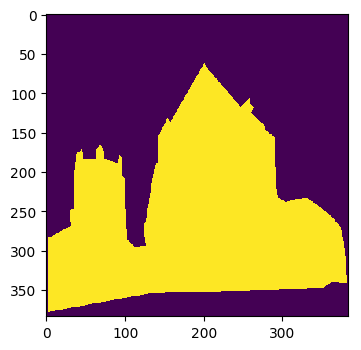

In [70]:
img2 = np.zeros(segmented.shape, dtype=np.uint8)
cnt = contour * scale
cv2.drawContours(img2, [cnt.astype(np.int32)], -1, 255, -1)
plt.imshow(img2)

In [74]:
intersection = cv2.bitwise_and(img1, img2)
union = cv2.bitwise_or(img1, img2)
score = intersection.sum() / float(union.sum())
print score

0.892852558159
